# Measuring Single Chip Performance on Tensor Processing Tasks


In [5]:
from pathlib import Path
import sys

from typing import Literal

import jax

platform : Literal["darwin", "colab", "cuda"] = "darwin"

try:
    import google.colab
    platform = "colab"
except ImportError:
    devices = jax.devices()
    if any(d.platform == "gpu" for d in devices):
        platform = "cuda"

print(f"Running on {platform}")

if platform == "colab":
    !git clone https://github.com/novastar53/high_performance_jax
    !git clone https://github.com/novastar53/deepkit
    hpj_dir = str(Path().absolute() / "high_performance_jax" / "src" )
    dt_dir = str(Path().absolute() / "deepkit" / "src" )

else:
    hpj_dir = str(Path().absolute().parent / "src" )
    dt_dir = str(Path().absolute().parent / "src" )


sys.path.append(hpj_dir)
print(hpj_dir)
sys.path.append(dt_dir)
print(dt_dir)

Running on colab
fatal: destination path 'high_performance_jax' already exists and is not an empty directory.
fatal: destination path 'deepkit' already exists and is not an empty directory.
/content/high_performance_jax/src
/content/deepkit/src


Devices:
TPU v6 lite
dim 4 | average time (ms): 0.13 | hbm xfer/s 7.21e+05 | flops 1.12e+02 | teraflops/s 0.0000
dim 8 | average time (ms): 0.13 | hbm xfer/s 3.06e+06 | flops 9.60e+02 | teraflops/s 0.0000
dim 16 | average time (ms): 0.13 | hbm xfer/s 1.21e+07 | flops 7.94e+03 | teraflops/s 0.0001
dim 32 | average time (ms): 0.13 | hbm xfer/s 4.89e+07 | flops 6.45e+04 | teraflops/s 0.0005
dim 64 | average time (ms): 0.13 | hbm xfer/s 1.94e+08 | flops 5.20e+05 | teraflops/s 0.0041
dim 128 | average time (ms): 0.13 | hbm xfer/s 7.83e+08 | flops 4.18e+06 | teraflops/s 0.0333
dim 256 | average time (ms): 0.12 | hbm xfer/s 3.22e+09 | flops 3.35e+07 | teraflops/s 0.2738
dim 512 | average time (ms): 0.12 | hbm xfer/s 1.26e+10 | flops 2.68e+08 | teraflops/s 2.1471
dim 1024 | average time (ms): 0.13 | hbm xfer/s 4.75e+10 | flops 2.15e+09 | teraflops/s 16.1995
dim 2048 | average time (ms): 0.15 | hbm xfer/s 1.70e+11 | flops 1.72e+10 | teraflops/s 115.8171
dim 4096 | average time (ms): 0.32 | hbm 

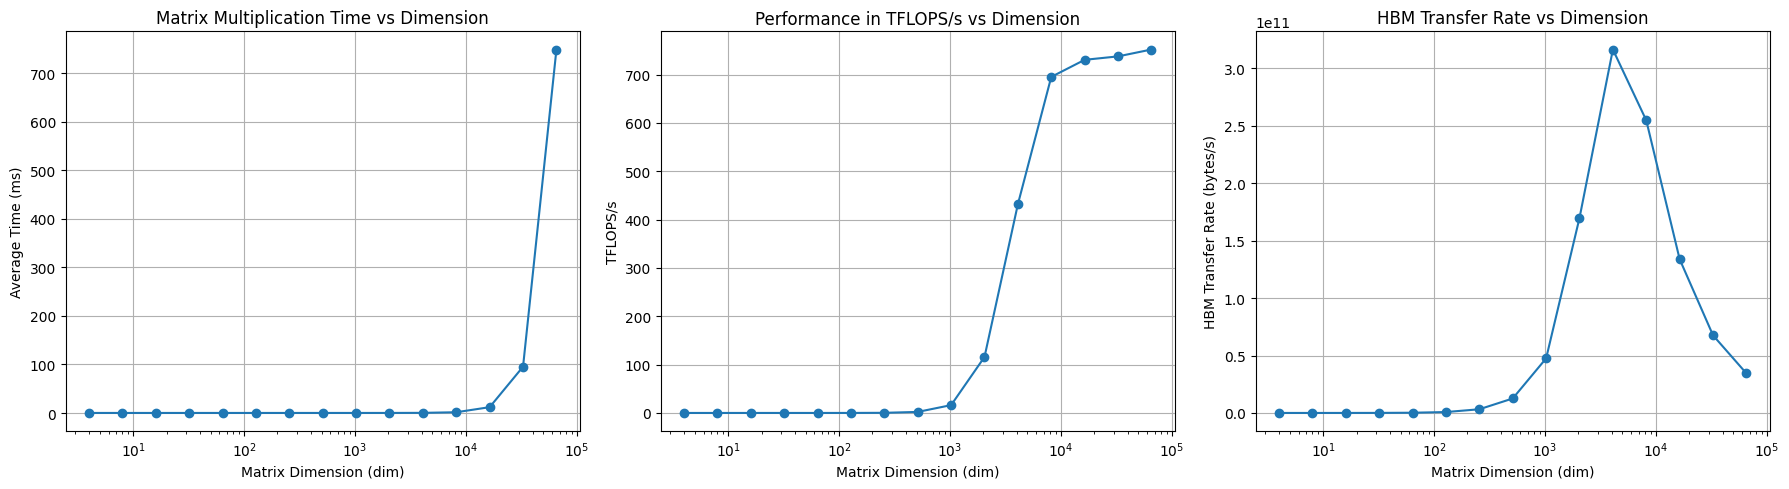

In [23]:
from high_performance_jax.single_chip_performance import *

dtype = jnp.bfloat16
devices = jax.devices()
print("Devices:")
for d in devices:
  print(d.device_kind)    # e.g. “TPU v3”


#####################################
##        jax.lax matmul presets   ##
#####################################
## 'ANY_F8_ANY_F8_F32',
## 'ANY_F8_ANY_F8_F32_FAST_ACCUM'
## 'ANY_F8_ANY_F8_ANY'
## 'ANY_F8_ANY_F8_ANY_FAST_ACCUM'
## 'F16_F16_F16'
## 'F16_F16_F32'
## 'BF16_BF16_BF16'
## 'BF16_BF16_F32'
## 'BF16_BF16_F32_X3'
## 'BF16_BF16_F32_X6'
## 'TF32_TF32_F32'
## 'TF32_TF32_F32_X3'
## 'F32_F32_F32'
## 'F64_F64_F64'
#####################################
jax.config.update("jax_default_matmul_precision", "BF16_BF16_F32") # Set the default precision for matrix multiplication

dims = [2**i for i in range(2, 17)]
times = []
tflops = []
hbm_rates = []

for dim in dims:
    A = jnp.ones((dim, dim), dtype=dtype)
    B = jnp.ones((dim, dim), dtype=dtype)
    task = "matmul"

    average_time_ms = timeit(jax.jit(matmul), A, B)
    flops = measure_tpu_flops(A, B, task)
    times.append(average_time_ms)
    tflops.append(1000 * flops / average_time_ms / 10**12)
    hbm_xfer = measure_tpu_hbm_memory_transfer(A, B, task, dtype)
    hbm_rates.append(1000 * hbm_xfer / average_time_ms)

    print(f"dim {dim} | average time (ms): {average_time_ms:.2f} | "
            f"hbm xfer/s {hbm_rates[-1]:.2e} | "
            f"flops {flops:.2e} | "
            f"teraflops/s {tflops[-1]:,.4f}")

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 5))

ax1.plot(dims, times, marker='o')
ax1.set_xscale('log')
ax1.set_xlabel("Matrix Dimension (dim)")
ax1.set_ylabel("Average Time (ms)")
ax1.set_title("Matrix Multiplication Time vs Dimension")
ax1.grid(True)

ax2.plot(dims, tflops, marker='o')
ax2.set_xscale('log')
ax2.set_xlabel("Matrix Dimension (dim)")
ax2.set_ylabel("TFLOPS/s")
ax2.set_title("Performance in TFLOPS/s vs Dimension")
ax2.grid(True)

ax3.plot(dims, hbm_rates, marker='o')
ax3.set_xscale('log')
ax3.set_xlabel("Matrix Dimension (dim)")
ax3.set_ylabel("HBM Transfer Rate (bytes/s)")
ax3.set_title("HBM Transfer Rate vs Dimension")
ax3.grid(True)

plt.tight_layout()
plt.show()

